In [460]:
import nltk
import numpy as np
import pandas as pd
import sqlite3
import pickle
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations 
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances
from nltk.corpus import stopwords
from sklearn.decomposition import NMF

# Initialize Databases

In [464]:
tags_conn = sqlite3.connect('lastfm_tags.db')

tags_tables = pd.read_sql_query(
    """
    SELECT * FROM sqlite_master;
    """
    , tags_conn)

tags_tables.tbl_name.unique()

array(['tags', 'tids', 'tid_tag'], dtype=object)

In [465]:
mxm_conn = sqlite3.connect('mxm_dataset.db')

schema_query = "SELECT * FROM sqlite_master;"
df_schema = pd.read_sql_query(schema_query, mxm_conn)
df_schema.tbl_name.unique()

array(['words', 'lyrics'], dtype=object)

# Import mismatched data to remove from sample

See post about data errors here: http://millionsongdataset.com/blog/12-1-2-matching-errors-taste-profile-and-msd/

In [496]:
sid_mismatches = pd.read_csv('sid_mismatches.txt',engine='python',header=None,index_col=False,sep='\s+')[2]
sid_mismatches = sid_mismatches.str.replace('>$',"").tolist()

# Sample Generation

#### Generate sample track ids by genre

In [ ]:
# genres=['rock','pop','folk','alternative','blues','country','electronic', 'Hip-Hop']
# samples_from_genre = {}
# for genre in genres:
#     sql = """
#         SELECT *
#         FROM tid_tag, tids, tags
#         WHERE tags.ROWID=tid_tag.tag
#             AND tid_tag.tid=tids.ROWID
#             AND tags.tag = '%s'
#             and tid_tag.val = 100
#         """%genre

#     df = pd.read_sql_query(sql, tags_conn)
#     samples_from_genre[genre] = df.sample(n=2000)

# genre_sample = pd.DataFrame()
# for key in samples_from_genre.keys():
#     genre_sample = genre_sample.append(samples_from_genre[key]) 
# genre_sample = genre_sample.reset_index().iloc[:,-2:]
# genre_sample = genre_sample.drop_duplicates(subset='tid')
# genre_sample = genre_sample.rename(columns={'tid':'track_id'})

# # removing songs mismatched in data
# genre_sample = genre_sample[~genre_sample['track_id'].isin(sid_mismatches)]
# with open('genre_sample.pickle', 'wb') as f:
#     pickle.dump(genre_sample, f, protocol=4)

In [504]:
with open('genre_sample.pickle', 'rb') as f:
    genre_sample = pickle.load(f)
print(f"There are {len(genre_sample['track_id'].value_counts())} from the following genres: {genres}")

There are 15290 from the following genres: ['rock', 'pop', 'folk', 'alternative', 'blues', 'country', 'electronic', 'Hip-Hop']


# Import all tags data on Sample Tracks

Random sample tags

In [59]:
# track_tags = pd.DataFrame()
# for item in sample['track_id'].iteritems():
#     tid = item[1]
#     sql = """
#     SELECT tags.tag, tid_tag.val
#     FROM tid_tag, tids, tags
#     WHERE tags.ROWID=tid_tag.tag AND tid_tag.tid=tids.ROWID and tids.tid='%s'
#     """ % tid

#     tags = pd.read_sql_query(sql, tags_conn)
#     tags['track_id'] = tid
#     track_tags = track_tags.append(tags).reset_index(drop=True)
    
# track_tags = track_tags.sort_values(by=['track_id','val'],ascending=[True,False])
# track_tags = track_tags[track_tags['val']==100] 
# with open('track_tags.pickle', 'wb') as f:
#     pickle.dump(track_tags, f, protocol=4)

In [60]:
# with open('track_tags.pickle', 'rb') as f:
#     track_tags = pickle.load(f)
# track_tags['tag'] = track_tags['tag'] +' genre'

# print(track_tags.sample(n=5))


# sorted_tags = track_tags.groupby(['tag']).count().reset_index().sort_values(by='val',ascending=False)
# sorted_tags['share of sample'] = sorted_tags['val']/sorted_tags['val'].sum()
# top10genres = sorted_tags['tag'].head(10).tolist()
# print()
# print(top10genres)

# track_tags_wide = track_tags.pivot(index='track_id',values='val',columns='tag').reset_index().fillna(0)
# track_tags_wide.head()

Sample from genres

In [497]:
# genre_track_tags = pd.DataFrame()
# for item in genre_sample['track_id'].iteritems():
#     tid = item[1]
#     sql = """
#     SELECT tags.tag, tid_tag.val
#     FROM tid_tag, tids, tags
#     WHERE tags.ROWID=tid_tag.tag AND tid_tag.tid=tids.ROWID and tids.tid='%s'
#     """ % tid

#     tags = pd.read_sql_query(sql, tags_conn)
#     tags['track_id'] = tid
#     genre_track_tags = genre_track_tags.append(tags).reset_index(drop=True)
    
# genre_track_tags = genre_track_tags.sort_values(by=['track_id','val'],ascending=[True,False])
# genre_track_tags = genre_track_tags[genre_track_tags['val']==100] 
# with open('genre_track_tags.pickle', 'wb') as f:
#     pickle.dump(genre_track_tags, f, protocol=4)

In [498]:
with open('genre_track_tags.pickle', 'rb') as f:
    track_tags = pickle.load(f)
track_tags['tag'] = track_tags['tag'] +' genre'

print(track_tags.sample(n=5))


sorted_tags = track_tags.groupby(['tag']).count().reset_index().sort_values(by='val',ascending=False)
sorted_tags['share of sample'] = sorted_tags['val']/sorted_tags['val'].sum()
top10genres = sorted_tags['tag'].head(10).tolist()
print()
print(top10genres)

track_tags_wide = track_tags.pivot(index='track_id',values='val',columns='tag').reset_index().fillna(0)
track_tags_wide[['track_id']+top10genres].head()

                      tag    val            track_id
4999        strange genre  100.0  TRMFVKK128F9324704
105202         folk genre  100.0  TRGSBVJ128F42633CF
292821      Hip-Hop genre  100.0  TRZLEPI128F1462491
230577   avantgarde genre  100.0  TRYJNOU12903CA9318
170098  alternative genre  100.0  TRDXGRU128F429F043

['rock genre', 'pop genre', 'alternative genre', 'electronic genre', 'folk genre', 'country genre', 'blues genre', 'Hip-Hop genre', 'indie genre', 'female vocalists genre']


tag            track_id  rock genre  pop genre  alternative genre  \
0    TRAABLR128F423B7E3         0.0        0.0                0.0   
1    TRAACMJ128F930C704       100.0        0.0              100.0   
2    TRAADEB128F9335868         0.0        0.0                0.0   
3    TRAAFFR128F42719EA         0.0        0.0                0.0   
4    TRAAFHD12903CEC1EF         0.0        0.0                0.0   

tag  electronic genre  folk genre  country genre  blues genre  Hip-Hop genre  \
0                 0.0         0.0          100.0        100.0            0.0   
1                 0.0         0.0            0.0          0.0            0.0   
2                 0.0         0.0            0.0          0.0          100.0   
3                 0.0         0.0            0.0          0.0          100.0   
4                 0.0         0.0            0.0        100.0            0.0   

tag  indie genre  female vocalists genre  
0            0.0                     0.0  
1          100.0                     0.0  
2            0.0                     0.0  
3            0.0                     0.0  
4            0.0                     0.0

# Import track names data

In [63]:
track_names = pd.read_csv("mxm_779k_matches.txt",skiprows=18,sep="<SEP>", header=None, engine='python')

track_names = track_names[[0,1,2]]
track_names.columns = ['track_id','artist name','title']

In [64]:
track_names[track_names['track_id']=='TRCCILA128F42BA535']

track_id           artist name     title
124927  TRCCILA128F42BA535  The Twilight Singers  Feathers

# Import word conversions data

In [127]:
word_convert = pd.read_csv("mxm_reverse_mapping.txt",skiprows=18,sep="<SEP>", header=None, engine='python')

word_convert.columns = ['word','full word']

track_id  mxm_tid    word count is_test         tag  \
0       TRQTONH12903CF38F7  1002138       i     2       0        rock   
1       TRQTONH12903CF38F7  1002138     the     6       0        rock   
2       TRQTONH12903CF38F7  1002138     you     4       0        rock   
3       TRQTONH12903CF38F7  1002138      to     2       0        rock   
4       TRQTONH12903CF38F7  1002138     and     4       0        rock   
...                    ...      ...     ...   ...     ...         ...   
167732  TREHPDX128F92DC86A  8269747    deni     3       0  electronic   
167733  TREHPDX128F92DC86A  8269747  asleep     1       0  electronic   
167734  TREHPDX128F92DC86A  8269747  bottom     1       0  electronic   
167735  TREHPDX128F92DC86A  8269747  mental     1       0  electronic   
167736  TREHPDX128F92DC86A  8269747   robot     2       0  electronic   

       full word _merge  
0              i   both  
1            the   both  
2            you   both  
3             to   both  
4            and   both  
...          ...    ...  
167732      deny   both  
167733    asleep   both  
167734    bottom   both  
167735    mental   both  
167736     robot   both  

[167737 rows x 8 columns]

# Import lyrics data 

Manual Track Lookup

In [452]:
tid = "TRULYTD12903CC53A0"
sql = """
SELECT m.track_id, m.mxm_tid, m.word, m.count, m.is_test
FROM lyrics as m
WHERE m.track_id='%s'
""" % tid
list1 = pd.read_sql_query(sql, mxm_conn).sort_values(by='word',ascending=False)['word'].tolist()
list2 = pd.read_sql_query(sql, mxm_conn).sort_values(by='word',ascending=False)['count'].tolist()
list(zip(list1,list2))

[]

#### Sample tracks data created here

Sample with genre

In [ ]:
# genre_sample_tracks = pd.DataFrame()
# errors = []
# for item in genre_sample['track_id'].iteritems():
#     tid = item[1]
#     sql = """
#     SELECT m.track_id, m.mxm_tid, m.word, m.count, m.is_test
#     FROM lyrics as m
#     WHERE m.track_id='%s'
#     """ % tid

#     words = pd.read_sql_query(sql, mxm_conn)
#     if len(words) == 0:
#         errors.append(tid)
#     words['track_id'] = tid
#     genre_sample_tracks = genre_sample_tracks.append(words)

# print(len(genre_sample_tracks['track_id'].value_counts()))
# # print(errors)

# with open('genre_sample_tracks.pickle', 'wb') as f:
#     pickle.dump(genre_sample_tracks, f, protocol=4)

In [522]:
with open('genre_sample_tracks.pickle', 'rb') as f:
    sample_tracks = pickle.load(f)

sample_tracks = sample_tracks.merge(genre_sample,on='track_id',how='left',validate='m:1')

# update stemmed words into their full version
sample_tracks = sample_tracks.merge(word_convert,on='word',how='left',validate='m:1',indicator = True)
print("displaying 5 random words to be updated from their stems")
print(sample_tracks[(sample_tracks['word']!=sample_tracks['full word'])&(sample_tracks['_merge']=='both')].sample(n=5)[['word','full word']])
sample_tracks.loc[sample_tracks['_merge']=='both','word'] = sample_tracks['full word'] 
sample_tracks = sample_tracks.drop(columns=['full word','_merge'])

# manual cleaning - beginning of word contracted 
sample_tracks.loc[sample_tracks['word']== "'bout",'word'] = 'about'
sample_tracks.loc[(sample_tracks['word']== "'cause") | (sample_tracks['word']=="'cos"),'word'] = 'because' 
sample_tracks.loc[sample_tracks['word']== "'em",'word'] = 'them'
sample_tracks.loc[sample_tracks['word']== "'fore", 'word'] = 'before'

# manual cleaning - end of word contracted 
sample_tracks.loc[sample_tracks['word']== 'yea','word'] = 'yeah'
sample_tracks.loc[sample_tracks['word']== "gon'", 'word'] = 'gonna'
sample_tracks.loc[sample_tracks['word']== "po'", 'word'] = 'po'
sample_tracks.loc[sample_tracks['word']== "piu'", 'word'] = 'piu'
sample_tracks.loc[sample_tracks['word']== "ol'", 'word'] = 'old'
sample_tracks.loc[sample_tracks['word']== "lil'", 'word'] = 'little'
sample_tracks.loc[sample_tracks['word']== "perche'", 'word'] = 'perche'
sample_tracks.loc[sample_tracks['word'].str.contains("'$"), 'word'] = sample_tracks['word'].str.replace("'$",'g')

sample_tracks = sample_tracks.groupby(['track_id','mxm_tid','word','is_test','tag']).sum().reset_index()

print()
print(f"total number of track is {len(sample_tracks.track_id.value_counts())}")
print(sample_tracks.groupby(['track_id','tag']).size().reset_index()['tag'].value_counts())
sample_tracks.sample(n=5)

displaying 5 random words to be updated from their stems
          word  full word
292747   final    finally
485957    yall      y'all
211270     whi        why
14564   embrac    embrace
50573    miser  miserable

total number of track is 6122
rock           1042
pop             959
country         956
alternative     948
folk            770
Hip-Hop         749
blues           360
electronic      338
Name: tag, dtype: int64


track_id  mxm_tid     word  is_test          tag  count
113220  TRFCHDD128EF354479  8797406     page        0      Hip-Hop      1
405527  TRSXEPD12903CE4AD5  2585491  someone        0      country      3
193458  TRISWMQ128F427FB79  1574638      mie        0  alternative      1
138094  TRGGCWF128F4248618  5236397    truth        0      Hip-Hop      1
354153  TRQMZTV128F4261E8C   897515    scars        0      Hip-Hop      1

In [523]:
sample_tracks[sample_tracks['track_id']=="TRDXIGQ128F1467E42"].sort_values(by='count',ascending=False).head(10)

track_id  mxm_tid  word  is_test      tag  count
87013  TRDXIGQ128F1467E42  1397029     a        1  Hip-Hop     14
87063  TRDXIGQ128F1467E42  1397029   que        1  Hip-Hop     11
87025  TRDXIGQ128F1467E42  1397029    do        1  Hip-Hop      7
87067  TRDXIGQ128F1467E42  1397029     s        1  Hip-Hop      7
87042  TRDXIGQ128F1467E42  1397029  mais        1  Hip-Hop      7
87054  TRDXIGQ128F1467E42  1397029     o        1  Hip-Hop      7
87051  TRDXIGQ128F1467E42  1397029    no        1  Hip-Hop      6
87091  TRDXIGQ128F1467E42  1397029    um        1  Hip-Hop      5
87024  TRDXIGQ128F1467E42  1397029    de        1  Hip-Hop      5
87026  TRDXIGQ128F1467E42  1397029     e        1  Hip-Hop      5

In [524]:
print(sample_tracks.columns)
print(sample_tracks.shape)


Index(['track_id', 'mxm_tid', 'word', 'is_test', 'tag', 'count'], dtype='object')
(563532, 6)


In [525]:
sample_tracks[sample_tracks['word'].str.contains("qu'$")]['word'].value_counts().tail(50)

Series([], Name: word, dtype: int64)

#### Add stop words here

In [526]:
custom_sw = ['would','because','cause','oh','ooh',"'til", 'gonna', 'oooh',
             'eh', 'hey', 'uhh', 'cha','ca', 'na'
            ]

nostops = sample_tracks.copy()[
    ~(sample_tracks['word'].isin(stopwords.words('english'))) &
    ~(sample_tracks['word'].isin(stopwords.words('french'))) &
    ~(sample_tracks['word'].isin(stopwords.words('german'))) &
    ~(sample_tracks['word'].isin(stopwords.words('spanish'))) & 
    ~(sample_tracks['word'].isin(stopwords.words('italian'))) & 
    (sample_tracks['word'].str.contains('[^0-9\W]')) &
    ~(sample_tracks['word'].isin(custom_sw))
    ]
nostops.shape

(341883, 6)

In [527]:
nostops.groupby(['track_id','tag']).size().reset_index()['tag'].value_counts()

rock           1042
pop             958
country         956
alternative     948
folk            770
Hip-Hop         747
blues           360
electronic      336
Name: tag, dtype: int64

#### Merge track names onto sample tracks

In [528]:
sample_tracks_names = nostops.merge(track_names,on='track_id',how='left',validate='m:1')

Data Analysis

In [534]:
total_counts = sample_tracks_names.groupby('track_id')['count'].sum().reset_index()
total_counts = total_counts.rename(columns={'count':'total word count'})
merge = sample_tracks_names.merge(total_counts, on='track_id',how='left',validate='m:1')
merge = merge.sort_values(by=['track_id','count'],ascending=[True,False])
merge['word share'] = merge['count'] / merge['total word count'] 
merge.drop_duplicates(subset='track_id',keep='first').sort_values(by='total word count',ascending=False).head(15)


track_id  mxm_tid     word  is_test          tag  count  \
254038  TRTOVVZ12903CE3188  4732026     beat        0      Hip-Hop     41   
271508  TRUYEDK128F4261A45   775223   wonder        0          pop     96   
73674   TRFLGCL128F92E389D  3160359     like        0      Hip-Hop     23   
293443  TRWKCTL128F42887BD  1534201     like        1      Hip-Hop      7   
294543  TRWLUSE128F4288B42  1320002     like        1      Hip-Hop      7   
19041   TRBKQJB128F934EEF7  5689498     fuck        0      Hip-Hop     48   
324018  TRYPHOG128F145DF4E   746133     shit        0         folk     15   
62329   TRESBVV128E079299C   987735      cry        0         rock     89   
173458  TRNFDLJ128F427733B  1502600     life        0      Hip-Hop     22   
303191  TRXBSRH128F9307213  4004764      let        0          pop     51   
296973  TRWPQIT128F4261E8E   897513      get        0      Hip-Hop     15   
289705  TRWCQQZ128F92F6543  1314012     like        0      Hip-Hop     18   
332868  TRZGTBI128F9304155  7112095       go        0      Hip-Hop     55   
217555  TRQSYLI128F423CC1E  8030015     boom        0  alternative     48   
321566  TRYKNFH128F1494327  2699519  another        0      Hip-Hop     31   

                 artist name                              title  \
254038    The Sugarhill Gang                   Rapper's Delight   
271508       Jessica Simpson                       My Wonderful   
73674            Binary Star                            The KGB   
293443               Canibus                   Poet Laureate II   
294543               Canibus                      Poet Laureate   
19041        Ying Yang Twins                  1st Booty On Duty   
324018       Dexter Freebish                       Falling Down   
62329          Guns N' Roses                          Don't Cry   
173458          Wu-Tang Clan                  A Better Tomorrow   
303191     Justin Timberlake                  Let's Take A Ride   
296973                 Big L                         8 Iz Enuff   
289705                Xzibit           What U See Is What U Get   
332868            Bizzy Bone                         Mercy Mary   
217555             Sean Paul                          Excite Me   
321566  The Notorious B.I.G.  Everyday Struggle (Album Version)   

        total word count  word share  
254038              1391    0.029475  
271508               649    0.147920  
73674                530    0.043396  
293443               528    0.013258  
294543               528    0.013258  
19041                520    0.092308  
324018               512    0.029297  
62329                477    0.186583  
173458               465    0.047312  
303191               453    0.112583  
296973               453    0.033113  
289705               450    0.040000  
332868               438    0.125571  
217555               437    0.109840  
321566               425    0.072941

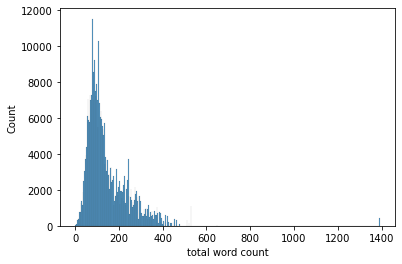

In [530]:
import seaborn as sns

g = sns.histplot(merge['total word count'])
# g.set(xlim=(0,50))

In [531]:
wordcountbygenre = sample_tracks_names.groupby(['tag','word'])['count'].sum().reset_index()
wordcountbygenre = wordcountbygenre.pivot(index='word',columns='tag',values='count').reset_index()

In [533]:
genres=['rock','pop','folk','alternative','blues','country','electronic', 'Hip-Hop']

for genre in genres:
    n = 5
    topwords = wordcountbygenre.sort_values(by=genre,ascending=False)['word'].head(n).tolist()
    topcounts = wordcountbygenre.sort_values(by=genre,ascending=False)[genre].head(n).tolist()
    top = {k:v for (k,v) in zip(topwords,topcounts)}
    print(f"Top {n} words for {genre} are {top}")

Top 5 words for rock are {'know': 1233.0, 'love': 1152.0, 'go': 1085.0, 'like': 1005.0, 'get': 888.0}
Top 5 words for pop are {'love': 2427.0, 'know': 1592.0, 'like': 1091.0, 'feel': 1005.0, 'time': 977.0}
Top 5 words for folk are {'love': 803.0, 'know': 701.0, 'like': 685.0, 'one': 601.0, 'go': 600.0}
Top 5 words for alternative are {'know': 1095.0, 'like': 914.0, 'go': 867.0, 'time': 832.0, 'love': 822.0}
Top 5 words for blues are {'baby': 621.0, 'know': 557.0, 'love': 466.0, 'got': 453.0, 'time': 350.0}
Top 5 words for country are {'love': 2060.0, 'know': 1154.0, 'like': 1105.0, 'time': 919.0, 'one': 890.0}
Top 5 words for electronic are {'love': 354.0, 'know': 348.0, 'go': 336.0, 'feel': 315.0, 'got': 264.0}
Top 5 words for Hip-Hop are {'like': 3135.0, 'get': 2271.0, 'got': 1792.0, 'know': 1596.0, 'one': 1241.0}


Make data wide for modelling

In [535]:
# reshape data into document-term matrix

sample_wide = sample_tracks_names[['track_id','mxm_tid','artist name','title','word','count','tag']].pivot(
                                    index=['track_id','mxm_tid','artist name','title','tag'],
                                    columns='word'
                                    ).reset_index()
sample_wide = sample_wide.fillna(0)
new_cols= []
for col in sample_wide.columns:
    if col[0] == 'count':
        new_cols += [col[1]+' word']
    else:
        new_cols += [col[0]+col[1]]
sample_wide.columns = new_cols
sample_wide = sample_wide.reindex(sample_wide.columns,axis=1)
sample_wide = sample_wide.merge(track_tags_wide,on='track_id',how='left',validate='1:1')

MemoryError: Unable to allocate 1.14 GiB for an array with shape (9662, 15856) and data type float64

In [ ]:
# preview data
sample_wide.head()

In [ ]:
# view top artists in sample

pd.DataFrame(sample_wide['artist name'].value_counts()).head(10)

# Topic Modelling

In [ ]:
model_data = sample_wide 
vocab = sample_wide.filter(regex=' word$',axis=1).columns.tolist() # list of words in order of column index

## NMF

In [ ]:
# fit the transfomed content with NMF

n_topics = 15
nmf = NMF(n_components=n_topics)
nmf.fit(model_data.filter(regex=' word$',axis=1))

In [ ]:
# display the result
from collections import defaultdict

top_words_dict = {}
top_words_count = defaultdict(int)
for index,topic in enumerate(nmf.components_):
    n = 20
    print(f"The top {n} words for topic # {index}")
    top_words =[vocab[i].replace(' word','') for i in topic.argsort()[:-1*n:-1]]
    print(top_words)
    print("\n")
    top_words_dict[index] = top_words
    for word in top_words:
        top_words_count[word]+=1

In [536]:
# # Overlapping words
# topic_top_words_df = pd.DataFrame.from_dict(top_words_count,orient='index').sort_values(by=0,ascending=False)
# topic_top_words_df[topic_top_words_df[0]>1]

In [ ]:
doc_topic = pd.DataFrame(nmf.transform(model_data.filter(regex=' word$',axis=1)))

In [ ]:
matrix = doc_topic.join(model_data.filter(regex='.*(?<! word)$',axis=1))
topic_n = 0
print(top_words_dict[topic_n])
matrix.sort_values(by=topic_n,ascending=False)[[topic_n,'track_id','artist name','title','tag']].head(10)

In [ ]:
matrix_long = matrix.melt(id_vars=['track_id','artist name','title','tag'], value_vars =list(range(n_topics)))
matrix_long

C:\Users\wal12\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


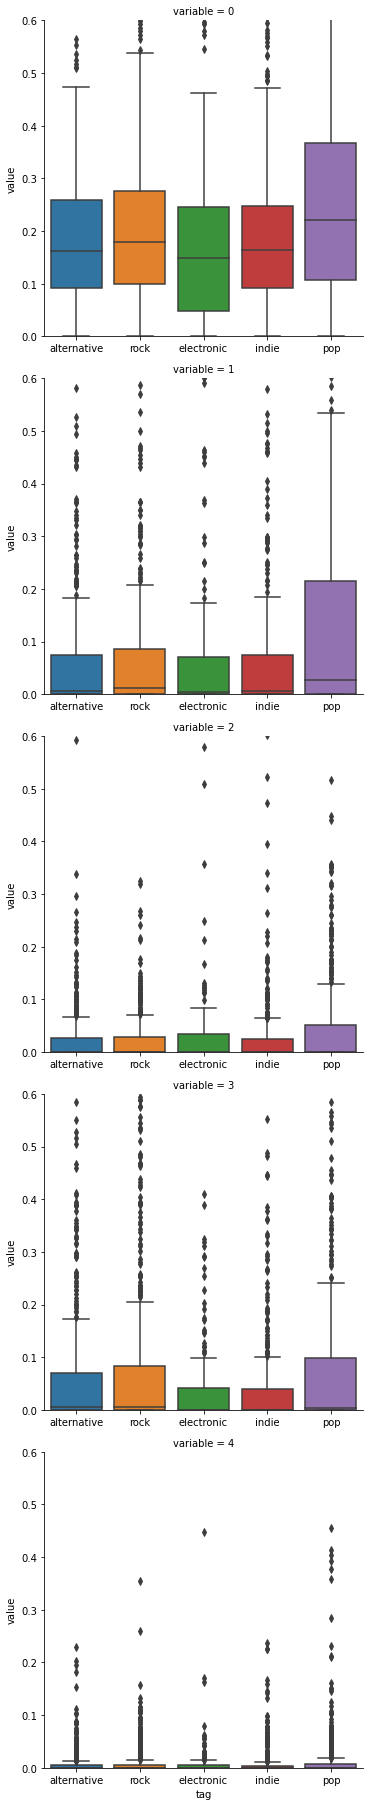

In [444]:
catplot = sns.catplot(data = matrix_long, x='tag',y='value',row='variable', kind='box',sharex=False,sharey=True)
catplot.set(ylim=(0,0.6));

In [282]:
# browse top words by track_id

track_word_count = sample_tracks_names[sample_tracks_names['track_id'] == 'TRCDMRL12903CB105C'][['track_id','tag','word','count']]
track_word_count.sort_values(by='count',ascending=False).head(20) #.pivot(index='track_id',columns='word')

track_id         tag      word  count
8512  TRCDMRL12903CB105C  electronic     booty    104
8517  TRCDMRL12903CB105C  electronic      move     92
8516  TRCDMRL12903CB105C  electronic      make     14
8513  TRCDMRL12903CB105C  electronic      dead     12
8518  TRCDMRL12903CB105C  electronic      must     12
8515  TRCDMRL12903CB105C  electronic       get      2
8510  TRCDMRL12903CB105C  electronic      acid      1
8511  TRCDMRL12903CB105C  electronic  anywhere      1
8514  TRCDMRL12903CB105C  electronic      easy      1

In [126]:
from sklearn.metrics.pairwise import pairwise_distances

pd.DataFrame(1-pairwise_distances(doc_topic, metric='cosine'))

0         1         2         3         4         5         6     \
0     1.000000  0.105067  0.190864  0.484113  0.827042  0.145218  0.028092   
1     0.105067  1.000000  0.375930  0.829919  0.446172  0.608272  0.637259   
2     0.190864  0.375930  1.000000  0.581942  0.505337  0.597027  0.579306   
3     0.484113  0.829919  0.581942  1.000000  0.791821  0.718832  0.701291   
4     0.827042  0.446172  0.505337  0.791821  1.000000  0.670011  0.581038   
...        ...       ...       ...       ...       ...       ...       ...   
4993  0.104114  0.178106  0.834108  0.325409  0.195230  0.157455  0.119201   
4994  0.008173  0.218362  0.804450  0.273810  0.127092  0.169139  0.142522   
4995  0.012207  0.416278  0.481457  0.562087  0.264304  0.424824  0.445678   
4996  0.127537  0.610627  0.421201  0.500382  0.479277  0.725250  0.660121   
4997  0.013845  0.632838  0.784296  0.618117  0.326179  0.490706  0.562114   

          7         8         9     ...      4988      4989      4990  \
0     0.026422  0.226830  0.161834  ...  0.689412  0.028088  0.015719   
1     0.561201  0.677903  0.207999  ...  0.544594  0.578063  0.428914   
2     0.819103  0.625949  0.168755  ...  0.245809  0.543089  0.389272   
3     0.668242  0.647775  0.215774  ...  0.597544  0.641448  0.453105   
4     0.553207  0.608388  0.256680  ...  0.674694  0.561309  0.362227   
...        ...       ...       ...  ...       ...       ...       ...   
4993  0.477509  0.268912  0.077865  ...  0.121420  0.112025  0.072198   
4994  0.475664  0.356352  0.102717  ...  0.183818  0.104550  0.247906   
4995  0.478021  0.420250  0.092513  ...  0.131250  0.411321  0.482649   
4996  0.636865  0.944508  0.414863  ...  0.608686  0.682283  0.624956   
4997  0.656680  0.589889  0.164390  ...  0.295022  0.477888  0.366291   

          4991      4992      4993      4994      4995      4996      4997  
0     0.225028  0.041999  0.104114  0.008173  0.012207  0.127537  0.013845  
1     0.911645  0.625751  0.178106  0.218362  0.416278  0.610627  0.632838  
2     0.489378  0.621655  0.834108  0.804450  0.481457  0.421201  0.784296  
3     0.887020  0.699002  0.325409  0.273810  0.562087  0.500382  0.618117  
4     0.543589  0.592667  0.195230  0.127092  0.264304  0.479277  0.326179  
...        ...       ...       ...       ...       ...       ...       ...  
4993  0.275047  0.183265  1.000000  0.961742  0.268026  0.120889  0.559527  
4994  0.271356  0.187703  0.961742  1.000000  0.237586  0.253127  0.554092  
4995  0.445755  0.451038  0.268026  0.237586  1.000000  0.290298  0.486182  
4996  0.422579  0.681012  0.120889  0.253127  0.290298  1.000000  0.340339  
4997  0.750044  0.562334  0.559527  0.554092  0.486182  0.340339  1.000000  

[4998 rows x 4998 columns]

# EDA

In [433]:
topics = []

for topic in nmf.components_:
    topic_words = {}
    for i in topic.argsort()[-20:]:
        word = vocab[i].replace(' word','')
        topic_words[word] = topic[i]
    print(topic_words)
    print()
    topics += [topic_words]

{'right': 1.5499456279112085, 'think': 1.6647835240301811, 'back': 1.7687621068486985, 'gonna': 1.804345342700298, 'life': 1.9332599069480358, 'caus': 1.9554602457728694, 'ca': 2.2007583946776146, 'feel': 2.218364313374764, 'take': 2.397251332743021, 'want': 2.4982360957975036, 'see': 2.5378018877406614, 'make': 2.58447560785529, 'time': 2.6257704348167668, 'way': 2.7138515134125623, 'say': 3.160677169280871, 'never': 3.23984081891212, 'got': 3.333610081241892, 'like': 4.3801545695653745, 'get': 4.510157149365522, 'know': 6.293191804060141}

{'like': 0.13585997843391143, 'end': 0.14419439494383005, 'hand': 0.1591230905702076, 'live': 0.16970348981559422, 'said': 0.18189006221229634, 'tear': 0.18305168614288553, 'sing': 0.18694011611424313, 'even': 0.18883383649877436, 'ghetto': 0.1976603676681758, 'youth': 0.19945365261892764, 'nuh': 0.24118831575844304, 'knew': 0.24203386304796756, 'hold': 0.24225435304874218, 'alright': 0.24336150005774224, 'eye': 0.2989160976666471, 'fi': 0.31953888

In [434]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [436]:
params = {'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
          
pylab.rcParams.update(params)

In [464]:
def plot_cloud_pairs(n_pairs = 2,topic_start=0):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=20,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    
    fig, axes = plt.subplots(n_pairs, 2, figsize=(10,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        cloud.generate_from_frequencies(topics[i+topic_start], max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+topic_start+1), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
#     return fig

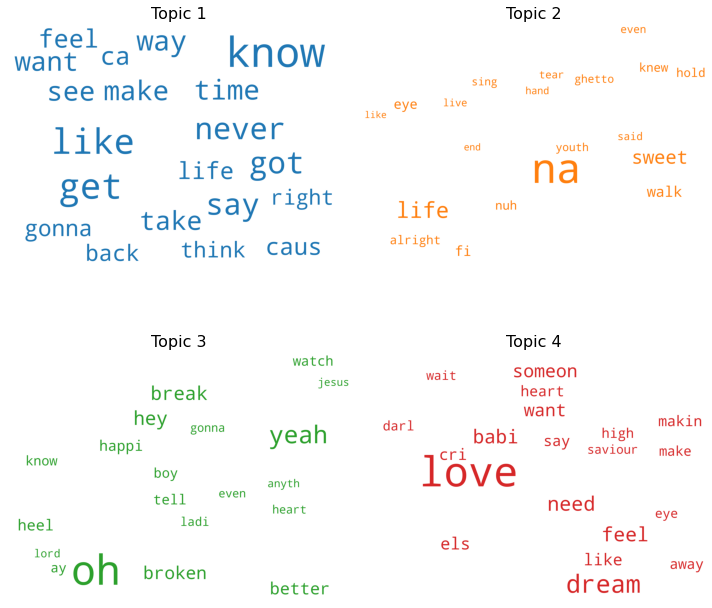

In [465]:
plot_cloud_pairs()

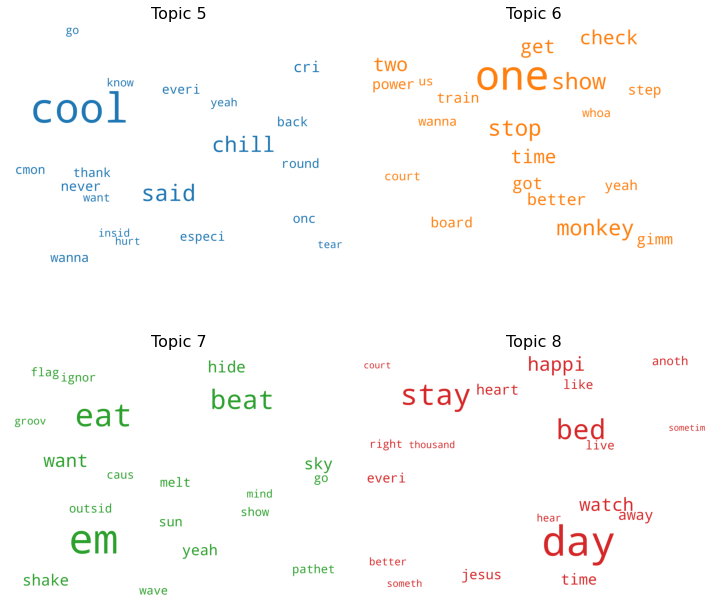

In [466]:
plot_cloud_pairs(n_pairs=2,topic_start=4)


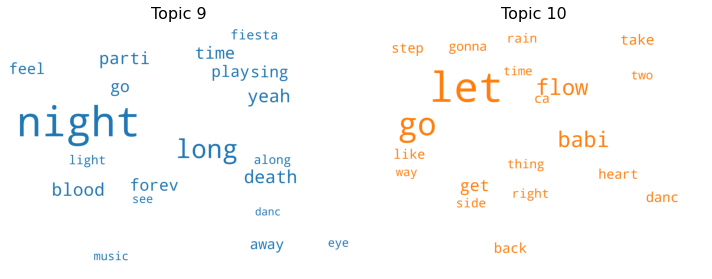

In [467]:
plot_cloud_pairs(n_pairs=1,topic_start=8)


In [ ]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)



# Appendix - old code

In [ ]:
# Old query for lyrics
# lyrics_query = """
# SELECT m.track_id, m.mxm_tid, m.word, m.count, m.is_test
# FROM lyrics as m
# INNER JOIN (SELECT DISTINCT track_id
#             FROM lyrics
#             WHERE is_test = 0
#             LIMIT 5000
#             ) as s
# ON m.track_id = s.track_id
# ORDER BY m.track_id
# """

# sample_tracks = pd.read_sql_query(lyrics_query, mxm_conn)


### LDA

In [294]:
from gensim import corpora, models, similarities, matutils

In [317]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Dense2Corpus(model_data.filter(regex=' word$',axis=1).to_numpy())

# save mapping of row id to word
id2word = {i:word.replace(' word','') for i, word in enumerate(vocab)}

In [322]:
lda = models.LdaModel(corpus = corpus, num_topics = 20, id2word=id2word, passes=5)

In [323]:
lda.print_topics()

[(0,
  '0.015*"disco" + 0.014*"defy" + 0.013*"coat" + 0.012*"beckon" + 0.011*"dieu" + 0.011*"awful" + 0.010*"conceal" + 0.010*"disaster" + 0.010*"bu" + 0.010*"dinero"'),
 (1,
  '0.010*"forget" + 0.007*"bird" + 0.007*"broke" + 0.007*"general" + 0.007*"liquor" + 0.007*"anda" + 0.007*"enter" + 0.006*"bike" + 0.006*"hang" + 0.006*"ears"'),
 (2,
  '0.039*"compare" + 0.025*"cafe" + 0.023*"house" + 0.018*"dine" + 0.015*"flip" + 0.015*"core" + 0.014*"comfort" + 0.014*"judge" + 0.013*"attack" + 0.013*"chin"'),
 (3,
  '0.015*"augen" + 0.015*"jugar" + 0.012*"depression" + 0.012*"déjà" + 0.012*"dread" + 0.010*"blind" + 0.009*"infected" + 0.009*"automatic" + 0.009*"hello" + 0.009*"five"'),
 (4,
  '0.010*"crave" + 0.009*"cabeza" + 0.009*"besser" + 0.007*"dig" + 0.007*"commit" + 0.006*"comb" + 0.006*"coz" + 0.006*"harder" + 0.006*"load" + 0.005*"joy"'),
 (5,
  '0.043*"legs" + 0.027*"doctor" + 0.027*"cough" + 0.020*"cent" + 0.020*"anywhere" + 0.017*"bonnie" + 0.016*"button" + 0.016*"depths" + 0.016*"h

In [321]:
# Transform the docs from the word space to the topic space
lda_corpus = lda[corpus]
lda_corpus

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

[[(0, 0.55501443),
  (1, 0.11382502),
  (3, 0.08060988),
  (8, 0.10287768),
  (11, 0.12943819)],
 [(0, 0.29006708), (7, 0.6173114)],
 [(7, 0.19919603), (11, 0.7313379)],
 [(0, 0.5416391),
  (1, 0.0416688),
  (2, 0.041669592),
  (3, 0.041668613),
  (4, 0.04166901),
  (5, 0.041670382),
  (6, 0.04166864),
  (7, 0.04166947),
  (8, 0.041669577),
  (9, 0.041669365),
  (10, 0.04166883),
  (11, 0.041668613)],
 [(7, 0.30926988), (9, 0.62915426), (11, 0.04526509)]]